In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
from utilities.dataset import CustomDataset
from utilities.constants import PATH, ROWS, COLS, TRAIN_SIZE, VALID_SIZE, TEST_SIZE
from utilities.transforms import transforms
from utilities.training import fit
from utilities.models import CarClassifierV0

/home/okechukwu/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = CustomDataset(root_dir=PATH, transforms=transforms)

In [3]:
len(ds) - TRAIN_SIZE - VALID_SIZE

371

In [4]:
train_ds, valid_ds, test_ds  = random_split(ds, [TRAIN_SIZE, VALID_SIZE, TEST_SIZE])

In [5]:
len(train_ds), len(test_ds)

(2264, 371)

In [6]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle = True)
test_dl = DataLoader(test_ds, shuffle = False)
valid_dl = DataLoader(valid_ds, shuffle = False)

In [7]:
train_image_batch, train_image_label = next(iter(train_dl))

In [8]:
class_names= list(ds.class_to_idx.keys())
class_names

['sandero',
 'chevroulet aveo',
 'mercedes class a',
 'hyundai tucson',
 'picanto',
 'toyota corolla',
 'bmw serie 1',
 'chevrolet spark',
 'duster',
 'polo',
 'megane',
 'octavia',
 'seat ibiza',
 'logan',
 'hyundai i10',
 'clio',
 'nemo citroen',
 'symbol',
 'Golf',
 'volkswagen tiguan']

In [9]:
train_image_batch[2], train_image_label[2], class_names[train_image_label[2].argmax()]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.]),
 'hyundai i10')

In [10]:
print(f'Shape of the each image -> {train_image_batch[0].shape}')

Shape of the each image -> torch.Size([3, 224, 224])


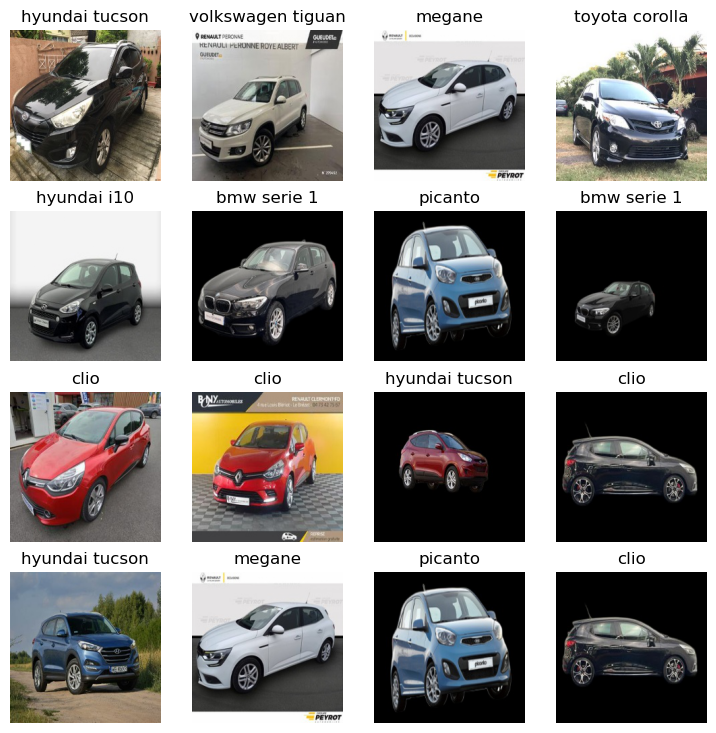

In [11]:
fig = plt.figure(figsize = (9,9))


for i in range(1, ROWS*COLS+1):
    random_idx = torch.randint(0, len(train_image_batch), size = [1]).item()
    img_data, label = train_image_batch[random_idx], train_image_label[random_idx]
    img = np.transpose(img_data.squeeze(), (1,2,0))
    fig.add_subplot(ROWS, COLS, i)
    plt.imshow(img)
    plt.title(class_names[label.argmax()])
    plt.axis('Off')

In [12]:
model_0 = CarClassifierV0(len(class_names))

In [13]:
model_0.parameters()

<generator object Module.parameters at 0x7f9d15628a50>

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr=1e-2)

In [15]:
history = fit(10, 1, model_0, train_dl, test_dl, criterion, optimizer, device = 'cpu')

  0%|          | 0/10 [00:00<?, ?it/s]

Epochs: 0


  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [32, 224, 3, 3], expected input[64, 3, 224, 224] to have 224 channels, but got 3 channels instead

In [18]:
train_image_batch[0].shape

torch.Size([3, 224, 224])